In [1]:
!pip3 install retentioneering

     |████████████████████████████████| 81kB 2.4MB/s 
     |████████████████████████████████| 1.3MB 8.4MB/s 


In [2]:
from retentioneering import init_config
import pandas as pd
import numpy as np
import io
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import IPython

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded=files.upload()


Saving online_shop_data_v1_1.csv to online_shop_data_v1_1.csv


In [0]:
data = pd.read_csv(io.StringIO(uploaded['online_shop_data_v1_1.csv'].decode('utf-8')),sep=',')

In [5]:
data.head()

,user_id,event_name,event_timestamp
0,8395097477884212984,https://sampleonlineshop.ru/?utm_source=blog,2019-09-02 05:38:46.852262656
1,4487962884362044925,https://sampleonlineshop.ru/?utm_source=blog,2019-09-01 21:51:42.811195648
2,5868438858211963279,https://sampleonlineshop.ru/?utm_source=facebook,2019-09-01 14:51:00.401165312
3,5394116602469871813,https://sampleonlineshop.ru/?utm_source=blog,2019-09-01 18:06:18.137125888
4,6285636856728637854,https://sampleonlineshop.ru/?utm_source=blog,2019-09-02 01:23:26.022273536


## Подготовка данных

In [0]:
user_id = 'user_id'
event_name = 'event_name'
event_time = 'event_timestamp'
source = 'utm_source'


target_events = ['https://sampleonlineshop.ru/order/submit'] # таргет событие

In [0]:
init_config(
    experiments_folder='experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col=user_id, # column by which we split users / sessions / whatever
    event_col=event_name, # column that describes event
    event_time_col=event_time, # column that describes timestamp of event
    positive_target_event='passed', # name of positive target event
    negative_target_event='lost', # name of negative target event
    pos_target_definition={ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
        'event_list':target_events
    },
    neg_target_definition={}
)

data = data.retention.prepare()

In [10]:
print('pos events:', len(data[data[event_name] == 'passed']))

pos events: 408


In [11]:
print('old events:', len(data[data[event_name] == 'https://sampleonlineshop.ru/order/submit']))

old events: 0


In [0]:
# убираем из названия событий общий префикс https://sampleonlineshop.ru/
data[event_name] = data[event_name].apply(lambda x: x.split('https://sampleonlineshop.ru/')[1] if x.find('https://sampleonlineshop.ru/') != -1 else x )

# выносим признак utm_source в отдельное поле
data[source] = data[event_name].apply(lambda x: x.split('?utm_source=')[1] if x.find('?utm_source=') != -1 else '')
data[event_name] = data[event_name].apply(lambda x: x.split('?utm_source=')[1] if x.find('?utm_source=') != -1 else x)

# выделим списки пользователей пришедших по разным каналам
users_facebook = set(data[data[source] == 'facebook'][user_id])
users_blog = set(data[data[source] == 'blog'][user_id])

data[source]= data.apply(lambda x: 'facebook' if (x[user_id] in users_facebook) else 'blog', axis = 1)

In [13]:
# обратим внимание на соотношение пользователей по РК
data[source].value_counts()

facebook    12816
blog         6372
Name: utm_source, dtype: int64

In [14]:

data.head(5)

,user_id,event_name,event_timestamp,utm_source
0,8150029619427326610,blog,2019-09-01 07:14:47.967690496,blog
1,3463487194338123780,blog,2019-09-01 08:31:45.484353280,blog
2,2163557180402591013,blog,2019-09-01 10:58:26.619910912,blog
15792,2163557180402591013,lost,2019-09-01 10:58:27.619910912,blog
3,5868438858211963279,facebook,2019-09-01 14:51:00.401165312,facebook


 Посмотрим траекторию одного пользователя

In [16]:
user=2163557180402591013
single_user_trajectory = data[data.user_id == user]
single_user_trajectory


,user_id,event_name,event_timestamp,utm_source
2,2163557180402591013,blog,2019-09-01 10:58:26.619910912,blog
15792,2163557180402591013,lost,2019-09-01 10:58:27.619910912,blog


Состав событий


In [17]:
data[event_name].drop_duplicates()

0                                             blog
15792                                         lost
3                                         facebook
24                                        catalog/
30                   catalog/divani/bed_bed_frame/
61                                      o-kompanii
80                                       delivery/
261        catalog/pillow/podushka_anatomicheskay/
320      catalog/matrasy/sampleonlineshop_gravity/
425                                         order/
485                             order/confirmation
617                                         passed
884                  order/payment-option-switcher
Name: event_name, dtype: object

### Граф

Посмотрим расположение событий в виде графа

Проверяем, что все события присутствуют, корректно отображаются. 

Однако, сделать вывод о проблемном месте по данной картине затруднительно

In [18]:
IPython.display.HTML(data
 .retention
 .plot_graph(thresh=0.05, width=800, height=800))

In [19]:
IPython.display.HTML(data
 .retention
 .plot_graph(node_params = {'facebook':'source','blog':'source', 'lost':'bad_target', 'passed': 'nice_target'},thresh=0.05, width=800, height=800))

Какие переходы между событиями есть в наших данных:


In [20]:
edgelist = data.retention.get_edgelist(edge_col='user_id', edge_attributes='users_nunique', norm=False)
edgelist.sort_values('users_nunique', ascending=False).head(5)

,event_name,next_event,users_nunique
35,facebook,catalog/,1610
9,catalog/,catalog/pillow/podushka_anatomicheskay/,881
38,facebook,lost,837
2,blog,catalog/divani/bed_bed_frame/,594
11,catalog/,lost,590


Построим матрицу переходов пользователей между событиями (матрицу связности)

In [21]:
df=data.retention.get_adjacency(edge_col='user_id', edge_attributes='users_nunique', norm=False)
import seaborn as sns
#from IPython.html import widgets
from IPython.display import HTML
def rotateheader():
    return  [
      #  dict(selector="th.col_heading",
    #             props=[("writing-mode", "vertical-rl"), 
     #                   ('transform', 'rotateZ(-45deg)'),
     #                   ])
     dict(selector="th", props=[("font-size", "75%"),
                            ("text-align", "right")
                         
                          ]),
        dict(selector="th.col_heading", props=[("font-size", "75%"),
                            ("text-align", "center"),
                          ("transform", "translate(0%,-140%) rotate(-15deg)")
                          ]),
             dict(selector="caption", props=[("caption-side", "bottom")])
]
 

cm = sns.light_palette("green", as_cmap=True)
print("\n\n\n")
df.style.background_gradient(cmap=cm).set_table_styles(rotateheader()).set_caption(" .")

,blog,catalog/,catalog/divani/bed_bed_frame/,delivery/,lost,o-kompanii,catalog/matrasy/sampleonlineshop_gravity/,catalog/pillow/podushka_anatomicheskay/,order/,order/confirmation,facebook,order/payment-option-switcher,passed
blog,150.000000,148.000000,594.000000,152.000000,348.000000,158.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/,0.000000,95.000000,426.000000,221.000000,590.000000,211.000000,234.000000,881.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/divani/bed_bed_frame/,0.000000,278.000000,409.000000,0.000000,473.000000,0.000000,0.000000,0.000000,228.000000,101.000000,0.000000,0.000000,0.000000
delivery/,79.000000,91.000000,0.000000,85.000000,347.000000,100.000000,0.000000,0.000000,0.000000,0.000000,295.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
o-kompanii,76.000000,84.000000,0.000000,181.000000,198.000000,82.000000,0.000000,0.000000,0.000000,0.000000,261.000000,0.000000,0.000000
catalog/matrasy/sampleonlineshop_gravity/,0.000000,44.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,50.000000,62.000000,28.000000,0.000000,0.000000
catalog/pillow/podushka_anatomicheskay/,122.000000,288.000000,0.000000,0.000000,371.000000,0.000000,0.000000,85.000000,146.000000,131.000000,0.000000,0.000000,0.000000
order/,19.000000,54.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,47.000000,0.000000,32.000000,267.000000,0.000000
order/confirmation,4.000000,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,0.000000,401.000000


Отнормируем матрицу на число уникальных пользователей


In [22]:

df=data.retention.get_adjacency(edge_col='user_id', edge_attributes='users_nunique', norm=True)
import seaborn as sns
#from IPython.html import widgets
from IPython.display import HTML
def rotateheader():
    return  [
      #  dict(selector="th.col_heading",
    #             props=[("writing-mode", "vertical-rl"), 
     #                   ('transform', 'rotateZ(-45deg)'),
     #                   ])
     dict(selector="th", props=[("font-size", "75%"),
                            ("text-align", "right")
                         
                          ]),
        dict(selector="th.col_heading", props=[("font-size", "75%"),
                            ("text-align", "center"),
                          ("transform", "translate(0%,-140%) rotate(-15deg)")
                          ]),
             dict(selector="caption", props=[("caption-side", "bottom")])
]
 

cm = sns.light_palette("green", as_cmap=True)
print("\n\n\n")
df.style.background_gradient(cmap=cm).set_table_styles(rotateheader()).set_caption(" .")


,blog,catalog/,catalog/divani/bed_bed_frame/,delivery/,lost,o-kompanii,catalog/matrasy/sampleonlineshop_gravity/,catalog/pillow/podushka_anatomicheskay/,order/,order/confirmation,facebook,order/payment-option-switcher,passed
blog,0.040000,0.040000,0.160000,0.040000,0.090000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/,0.000000,0.030000,0.110000,0.060000,0.160000,0.060000,0.060000,0.230000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/divani/bed_bed_frame/,0.000000,0.070000,0.110000,0.000000,0.120000,0.000000,0.000000,0.000000,0.060000,0.030000,0.000000,0.000000,0.000000
delivery/,0.020000,0.020000,0.000000,0.020000,0.090000,0.030000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
o-kompanii,0.020000,0.020000,0.000000,0.050000,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000
catalog/matrasy/sampleonlineshop_gravity/,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.020000,0.010000,0.000000,0.000000
catalog/pillow/podushka_anatomicheskay/,0.030000,0.080000,0.000000,0.000000,0.100000,0.000000,0.000000,0.020000,0.040000,0.030000,0.000000,0.000000,0.000000
order/,0.010000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.070000,0.000000
order/confirmation,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.110000


Какие петли и какие вообще паттерны есть в траекторих пользователей, какие из них коррелируют с оттоком пользователей, а какие с конверсией

Петли:

In [23]:
loops = data.retention.find_loops()
loops.sort_values(['Lost2Good'],ascending = False).head(20)

,Sequence,Good,Lost,Lost2Good,GoodUnique,LostUnique,UniqueLost2Good
2,blog,6,21,3.500000,6,16,2.666667
3,catalog/pillow/podushka_anatomicheskay/,10,19,1.900000,6,11,1.833333
4,catalog/,8,14,1.750000,7,12,1.714286
0,catalog/divani/bed_bed_frame/,77,123,1.597403,45,40,0.888889
5,o-kompanii,12,10,0.833333,9,9,1.000000
1,facebook,48,39,0.812500,46,38,0.826087
7,delivery/,8,4,0.500000,7,4,0.571429
6,order/,19,6,0.315789,17,5,0.294118
8,order/payment-option-switcher,37,3,0.081081,30,2,0.066667


Подпоследовательности:


In [24]:
sequences = data.retention.find_sequences(ngram_range=(2,6), exclude_cycles = False,exclude_loops = False)
sequences[sequences['Good']!=0].sort_values(['Lost2Good'],ascending = False).head(20)

,Sequence,Good,Lost,Lost2Good
19,catalog/divani/bed_bed_frame/~~catalog/divani/...,3.0,24.0,8.000000
69,catalog/pillow/podushka_anatomicheskay/~~catal...,1.0,7.0,7.000000
12,catalog/divani/bed_bed_frame/~~catalog/divani/...,6.0,37.0,6.166667
86,catalog/~~catalog/pillow/podushka_anatomichesk...,1.0,5.0,5.000000
90,catalog/pillow/podushka_anatomicheskay/~~catal...,1.0,5.0,5.000000
109,order/~~catalog/~~catalog/pillow/podushka_anat...,1.0,5.0,5.000000
91,catalog/~~catalog/matrasy/sampleonlineshop_gra...,1.0,5.0,5.000000
96,catalog/pillow/podushka_anatomicheskay/~~catal...,1.0,5.0,5.000000
117,blog~~catalog/~~catalog/pillow/podushka_anatom...,1.0,5.0,5.000000
100,catalog/divani/bed_bed_frame/~~catalog/divani/...,1.0,5.0,5.000000


### Кластеризация

Сделаем кластеризацию и оценим, на какие кластеры распадаются наши данные по конверсии

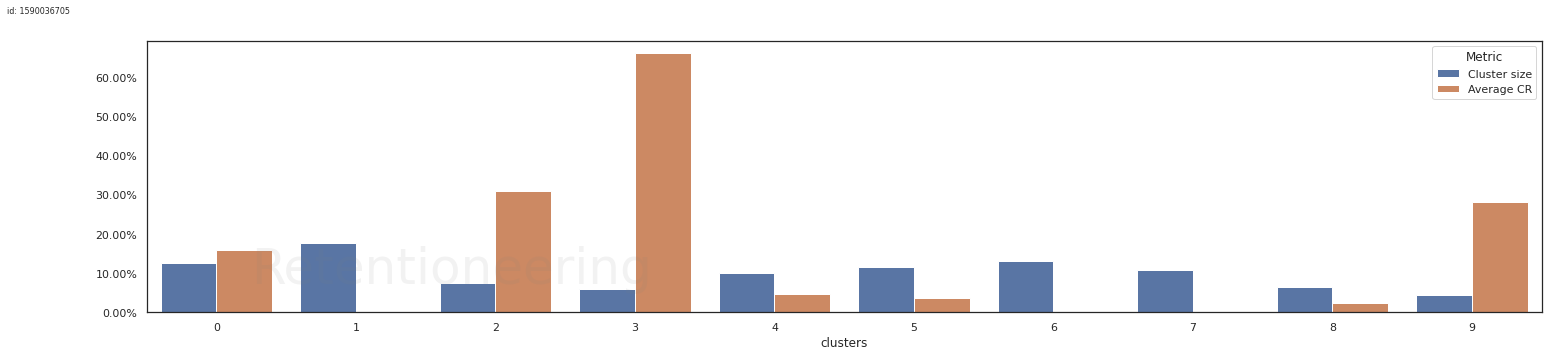

In [40]:
data.retention.get_clusters(plot_type='cluster_bar', n_clusters=10, refit_cluster = True,ngram_range=(1,2));

Построим TSNE проекцию пользователей из TF-IDF пространства:

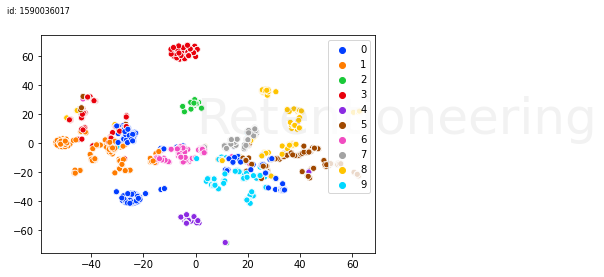

In [26]:
data.retention.project(method='tsne', plot_type='clusters');

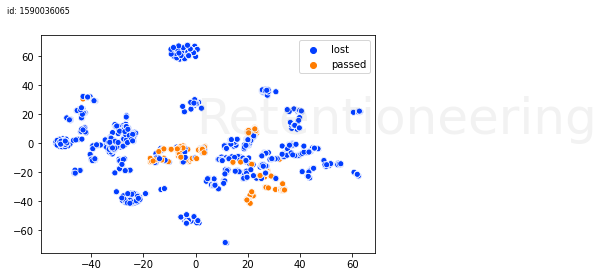

In [28]:
data.retention.project(method='tsne', plot_type='targets');

Построим граф для кластера:

In [29]:
IPython.display.HTML(data
 .retention
 .filter_cluster(6)
 .retention
 .plot_graph(width=800, height=800))

In [30]:
IPython.display.HTML(data
 .retention
 .filter_cluster(8)
 .retention
 .plot_graph(width=800, height=800))

Исследуем профиль этого кластера - какие события как часто вызывались пользователями этого кластера

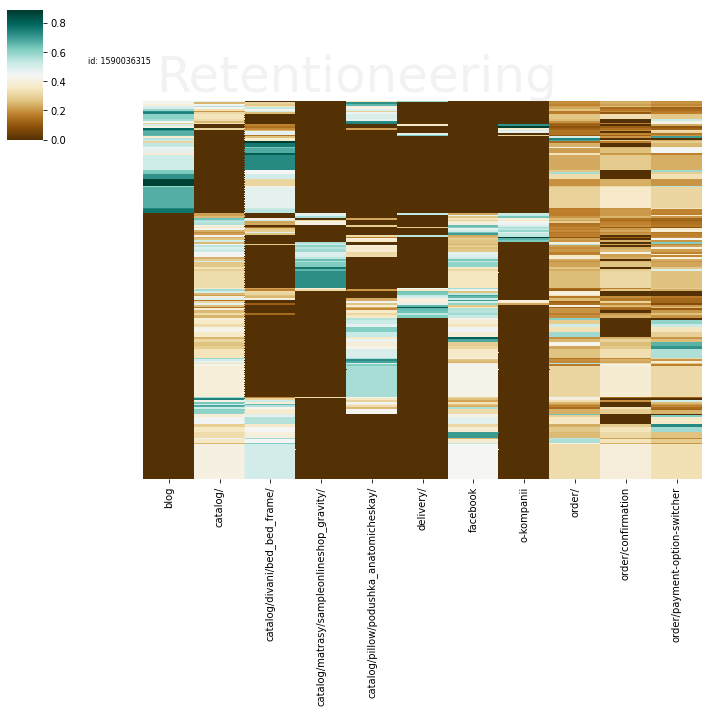

In [32]:
data.retention.filter_cluster(6).retention.get_clusters(plot_type='cluster_heatmap');

Более детальное рассмотрение Топ-10 событий кластера и сравнение со всеми пользователями всех кластеров

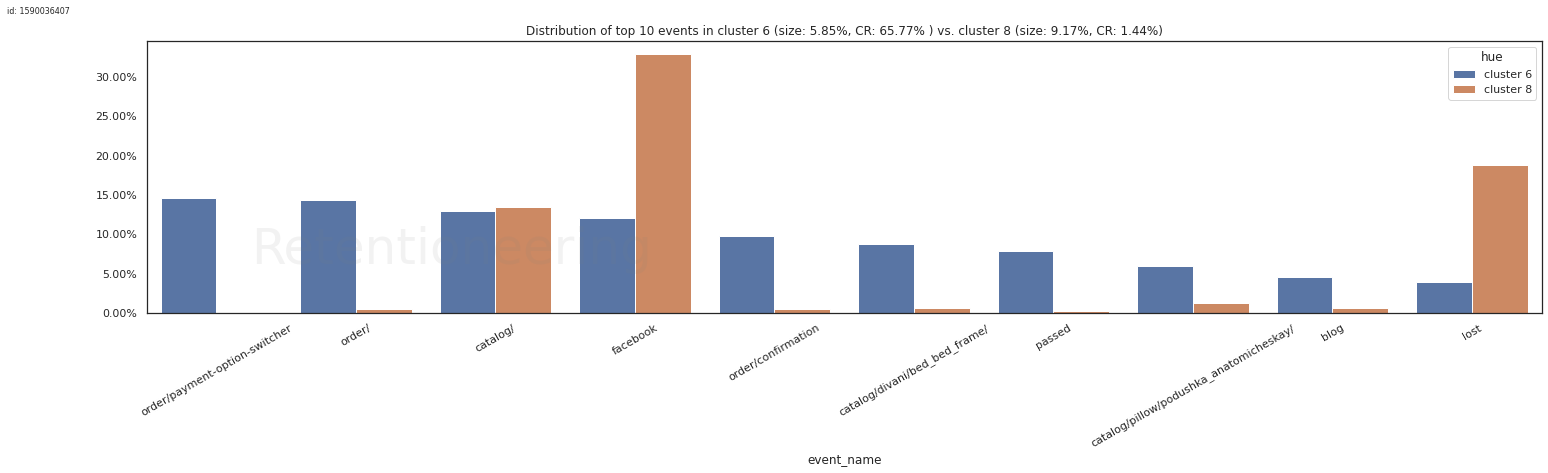

In [35]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(25,5)})
data.retention.cluster_event_dist(6,8, n=10)

Расширим N-граммы длинны 1 до N-грамм длинны 2: учтем переходы

array([0, 4, 3, ..., 2, 3, 2], dtype=int32)

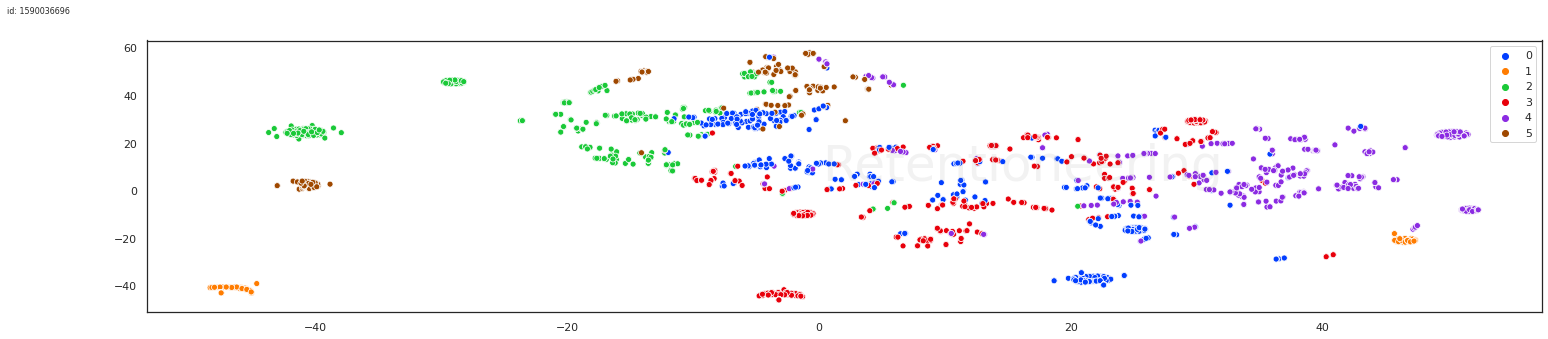

In [39]:
data.retention.get_clusters(n_clusters=6, plot_type='cluster_tsne', refit_cluster=True,ngram_range=(1,2))

Сколько у нас уникальных событий:

In [27]:
data['event_name'].nunique()


13

Сколько уникальных переходов:

In [37]:
edgelist = data.retention.get_edgelist()
edgelist.shape[0]

61

array([5, 3, 3, ..., 4, 1, 4], dtype=int32)

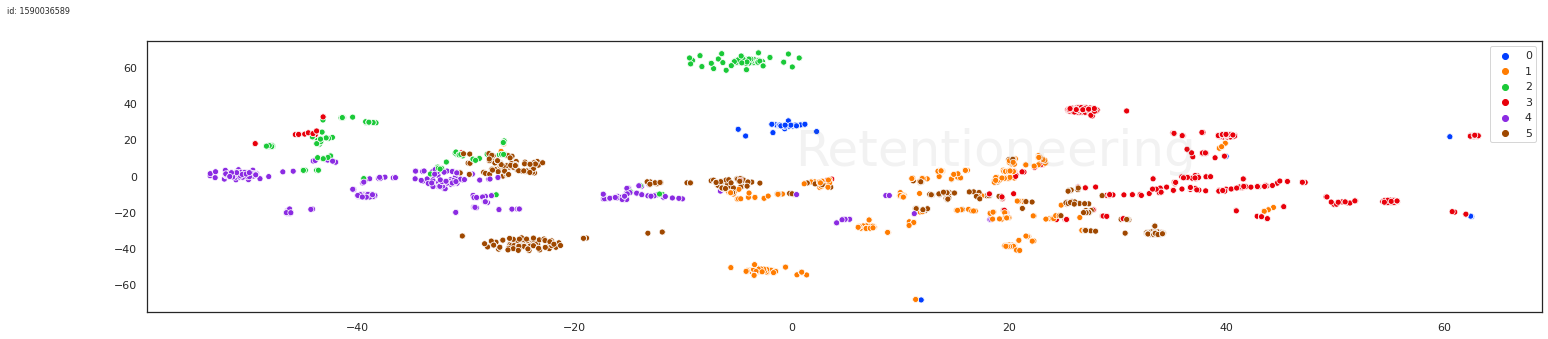

In [38]:
data.retention.get_clusters(n_clusters=6, plot_type='cluster_tsne', refit_cluster=True,ngram_range=(1,1))
